> **Table of Contents:**
> * [Importing Libraries](#1)
> * [Loading Data](#2)
> * [EDA - Exploratory Data Analysis](#3)
> * [PreProcessing](#4)
> * [Tokenization and Padding](#5)
> * [Model and Predictions](#6)
> ---

<a id="1"></a> 
## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
nltk.download("stopwords")

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="2"></a> 
# 2. Loading the Data

In [2]:
# setting the names of the columns into col_names

col_names = ["target", "ids", "date", "flag", "user", "text"]
# reading the data from the path and using ISO-8859-1 encoding to decode it.

df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
            encoding = "ISO-8859-1",
            names=col_names)

In [3]:
df = df.sample(160000) # taking 160k rows from the data
df.head()

,target,ids,date,flag,user,text
600955,0,2221031320,Thu Jun 18 04:32:50 PDT 2009,NO_QUERY,Jessiesaurusrex,everyday that passes makes it hurt a little mo...
341468,0,2015048020,Wed Jun 03 03:32:15 PDT 2009,NO_QUERY,eheggart,@electric_blueee no worries. Going to give tim...
1247337,4,1995527988,Mon Jun 01 13:38:05 PDT 2009,NO_QUERY,lanarushing,June gloom is no match for me. Getting lots d...
749746,0,2285208713,Mon Jun 22 14:50:37 PDT 2009,NO_QUERY,zoomzoompow,Is anyone even listening to me? Hello? Anybody...
99865,0,1793768374,Thu May 14 03:55:34 PDT 2009,NO_QUERY,nurse_on_duty,I hate it!!!! Tanggal si Danny!!!!! Nooooo!!!!...


<a id="3"></a> 
# 3. Let's Explore


In [4]:
df.info() # shows the columns, and their types.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160000 entries, 600955 to 216511
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  160000 non-null  int64 
 1   ids     160000 non-null  int64 
 2   date    160000 non-null  object
 3   flag    160000 non-null  object
 4   user    160000 non-null  object
 5   text    160000 non-null  object
dtypes: int64(2), object(4)
memory usage: 8.5+ MB


In [5]:
df.shape

(160000, 6)

In [6]:
df.describe(include='all') # To statistical measures of the columns

,target,ids,date,flag,user,text
count,160000.000000,1.600000e+05,160000,160000,160000,160000
unique,NaN,NaN,143799,1,123407,159430
top,NaN,NaN,Thu Jun 04 08:02:50 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,5,160000,52,22
mean,2.006275,1.997689e+09,NaN,NaN,NaN,NaN
std,1.999996,1.943368e+08,NaN,NaN,NaN,NaN
min,0.000000,1.467812e+09,NaN,NaN,NaN,NaN
25%,0.000000,1.956560e+09,NaN,NaN,NaN,NaN
50%,4.000000,2.001936e+09,NaN,NaN,NaN,NaN
75%,4.000000,2.176930e+09,NaN,NaN,NaN,NaN


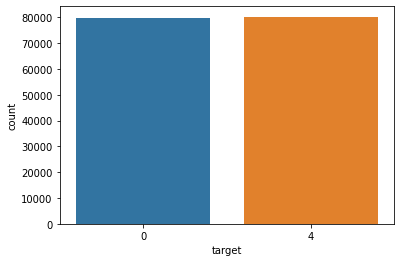

In [7]:
sns.countplot(x=df['target']); # shows a count plot refering to the number of 0 and 4 in the column

In [8]:
df = df.drop(['ids', 'date', 'flag','user'], axis = 1) # dropping unnecessary columns

In [9]:
df.head()

,target,text
600955,0,everyday that passes makes it hurt a little mo...
341468,0,@electric_blueee no worries. Going to give tim...
1247337,4,June gloom is no match for me. Getting lots d...
749746,0,Is anyone even listening to me? Hello? Anybody...
99865,0,I hate it!!!! Tanggal si Danny!!!!! Nooooo!!!!...


<a id="4"></a> 
## 4. Preprocessing

Here 0 represents as negative and 4 as positive so lets change 4 to 1.

In [10]:
df['target']=df['target'].replace(4,1) 

In [11]:
data = df['text']
labels = np.array(df['target'])

In [12]:
data.iloc[1] # displaying a row of the data

'@electric_blueee no worries. Going to give time for revision in class so you can ask me then. Rep sport cancelled... again '

In [13]:
# this function is copied from another kernel. Don't know who is the original author of it.
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)
def tweet(words):
    tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,reduce_len=True)
    tweet = tweet_tokenizer.tokenize(words)
    return tweet
        

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [14]:
data = data.apply(denoise_text)

To see the difference in before and after applying stopwords function.

In [15]:
print('Before: {}'. format(list(df['text'][:2])))
print('---')
print('After: {}'. format(list(data[:2])))

Before: ['everyday that passes makes it hurt a little more... I really liked him... ', '@electric_blueee no worries. Going to give time for revision in class so you can ask me then. Rep sport cancelled... again ']
---
After: ['everyday passes makes hurt little really liked', 'electricblueee worries going give time revision class ask rep sport cancelled']


In [16]:
print(f"dataset contains {len(data)} examples\n")

print(f"Text of second example should look like this:  {data.iloc[1]}\n")
print(f"Text of fourth example should look like this:  {data.iloc[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 160000 examples

Text of second example should look like this:  electricblueee worries going give time revision class ask rep sport cancelled

Text of fourth example should look like this:  anyone even listening hello anybody followers ignoring like else thought people would different

Labels of last 5 examples should look like this:
[0 1 1 0 0]


## Splitting the Data

In [17]:
# Split in training validation and test sets
X_train, X_test, y_train, y_test = test = train_test_split(data, labels,test_size=0.20,
                                                           random_state=1,
                                                           stratify = labels)

<a id="5"></a> 
## 5. Tokenization

In [18]:
# lets take 10k words in num_words
tokenizer = Tokenizer(num_words=10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)+1
VOCAB_SIZE

116167

In [19]:
maxlen = max([len(x) for x in X_train]) # return 175 which is too big for tweets data.
maxlen = 50

### Sequencing and Padding

In [20]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded_sequences = pad_sequences(train_sequences,maxlen=maxlen,padding='post',truncating='post')
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded_sequences = pad_sequences(test_sequences,maxlen=maxlen,padding='post',truncating='post')

In [21]:
len(train_padded_sequences[0])

50

<a id="6"></a> 
## 6. Model Training and Results

In [22]:
embedding_dim = 32

In [23]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE+1, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(embedding_dim,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ])

model.compile(loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

2022-11-17 10:19:50.802082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 10:19:50.803523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 10:19:50.953025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 10:19:50.954334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 10:19:50.955580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [24]:
#summary of the model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            3717376   
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                6272      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                1

In [25]:
# Training the model we created above. 
history =    model.fit(train_padded_sequences,
                                               y_train,
                                               validation_data = (test_padded_sequences, y_test),
                                               epochs = 3)

2022-11-17 10:19:55.579772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-11-17 10:19:59.380323: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


4000/4000 [==============================] - 160s 38ms/step - loss: 0.5529 - accuracy: 0.7201 - val_loss: 1.6349 - val_accuracy: 0.5463
Epoch 2/3
4000/4000 [==============================] - 124s 31ms/step - loss: 0.4820 - accuracy: 0.7714 - val_loss: 0.4850 - val_accuracy: 0.7670
Epoch 3/3
4000/4000 [==============================] - 101s 25ms/step - loss: 0.4537 - accuracy: 0.7873 - val_loss: 0.4849 - val_accuracy: 0.7690


In [26]:
print(X_test.iloc[99],'label: ;',y_test[99])

todays gonna looong day label: ; 0


In [27]:
tokenizer.sequences_to_texts(test_padded_sequences)[99]

'todays gonna looong day <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>'

In [28]:
model.predict(test_padded_sequences)[99]

array([0.5303677], dtype=float32)

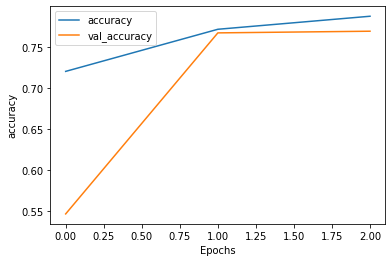

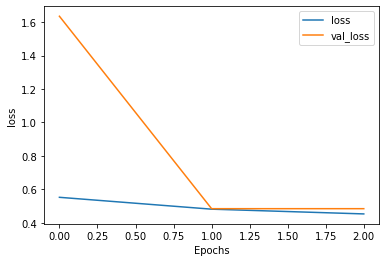

In [29]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")